In [1]:
import tensorflow as tf
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras import layers
#from keras.layers import BatchNormalization
from keras.models import Model
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import  PCA
from mpl_toolkits.mplot3d import Axes3D
import IPython
import librosa.display
import librosa
import pickle

In [2]:
with open('/Users/mezaga93/Desktop/waveforms_ordered.pkl', 'rb') as f:
  waveforms = pickle.load(f)

In [3]:
###normalizar y cambio de dimensionalidad
mu_wave = np.mean(waveforms, axis= 1)[...,np.newaxis]
max_wave = np.max(waveforms, axis=1)[...,np.newaxis]

Xw = (waveforms-mu_wave)/max_wave
print(Xw.shape)

(8970, 16000)


In [4]:
#####reshape de los datos
Xw = Xw[...,np.newaxis][...,np.newaxis]
print(Xw.shape)

(8970, 16000, 1, 1)


In [47]:
optimizer = tf.keras.optimizers.Adam(0.0001)
latent_dim = 128
sr = 48000
sr16k = 16000
fx = ["Clean", "TubeScreamer", "BluesDriver", "RAT", "Chorus", "Phaser", "Flanger", "Tape Echo","Sweep Echo", "Digital Delay", "Hall Reverb", "PlateReverb", "Spring Reverb"]

In [6]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    #@tf.function
    def call(self, inputs):
        z_mean, z_log_var = inputs
        #z_mean = np.array([input[0]])
        #z_log_var = np.array([input[1]])
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [7]:
class KLDivergenceRegularizer(tf.keras.regularizers.Regularizer):
  def __init__(self, iters: tf.Variable, warm_up_iters: int, latent_size: int):
    self._iters = np.array([iters])
    self._warm_up_iters = np.array([warm_up_iters])
    self.latent_size = latent_size
  
  @tf.function
  def __call__(self, activation):
    # note: activity regularizers automatically divide by batch size
    mu= activation[:self.latent_size]
    log_var = activation[self.latent_size:]
    k = np.min(self._iters / self._warm_up_iters)
    return -0.5 * k * K.sum(1+ log_var - K.square(mu) - K.exp(log_var))

In [8]:
warm_up_iters = 1000 
optimizer = tf.keras.optimizers.Adam(0.0001)

In [14]:
latent_dim = 128
original_dim = (sr16k, 1, 1)
encoder_inputs = keras.Input(original_dim)                                                   # bat, samps, ?, ch
x = layers.Conv2D(64, (66,1), activation="relu", padding="same",strides=(4,1))(encoder_inputs) # [69, 48000, 1, 1] -> [69, 12000, 1, 64]
x = layers.Conv2D(128,(66,1), activation="relu", padding="same",strides=(4,1))(x)
x = layers.Conv2D(256,(66,1), activation="relu", padding="same",strides=(4,1))(x)
latent = layers.Conv2D(512,(66,1), activation="relu", padding="same",strides=(3,1))(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(units=latent_dim, name='Z-Mean')(x) # Mean component
z_log_sigma = layers.Dense(units=latent_dim, name='Z-Log-Sigma')(x) # Standard deviation component
#######que pasa con z_regular nunca se usa?
z_regular = tf.keras.layers.Concatenate(activity_regularizer= KLDivergenceRegularizer(optimizer.iterations, warm_up_iters,latent_dim))([z_mean,z_log_sigma])
z = Sampling()([z_mean, z_log_sigma])
#z = Sampling()(z_regular)
vae_encoder = keras.Model(encoder_inputs, [z_mean, z_log_sigma, z], name="encoder_vae")
vae_encoder.summary()

Model: "encoder_vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 16000, 1, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 4000, 1, 64)  4288        ['input_3[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 1000, 1, 128  540800      ['conv2d_4[0][0]']               
                                )                                                                 
                                                                                        

In [15]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(250 * 1 * 256, activation="relu")(latent_inputs)
x = layers.Reshape((250, 1, 256))(x)
#x = layers.Conv2DTranspose(512,(4,1), activation="relu",padding= "same",strides= (3,1))(x)
x = layers.Conv2DTranspose(128,(66,1), activation="relu",padding= "same",strides= (4,1))(x)
x = layers.Conv2DTranspose(64,(66,1), activation="relu",padding= "same",strides= (4,1))(x)
#x = layers.Conv2DTranspose(64,(16,1), activation="relu",padding= "same",strides=(4,1))(x)
decoder_outputs = layers.Conv2DTranspose(1, (66, 1), activation="tanh", padding="same", strides = (4,1))(x)
vae_decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder_vae")
vae_decoder.summary()

Model: "decoder_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_3 (Dense)             (None, 64000)             8256000   
                                                                 
 reshape_1 (Reshape)         (None, 250, 1, 256)       0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 1000, 1, 128)     2162816   
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 4000, 1, 64)      540736    
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 16000, 1, 1)      

In [16]:
# Define outputs from a VAE model by specifying how the encoder-decoder models are linked
outpt = vae_decoder(vae_encoder(encoder_inputs)[2]) # note, outputs available from encoder model are z_mean, z_log_sigma and z. We take z by specifying [2]
# Instantiate a VAE model
vae = Model(inputs=encoder_inputs, outputs=outpt, name='VAE-Model')
vae.compile(optimizer= optimizer,loss = 'mean_squared_error')

#vae.summary()

In [17]:
vae.load_weights("/Users/mezaga93/Desktop/checkpoints/checkpoint")
acc= vae.evaluate(Xw, Xw)
print("Untrained model,error: {:5.2f}%".format(100 * acc))

2022-05-31 22:31:37.713500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


281/281 [==============================] - 63s 224ms/step - loss: 0.0024
Untrained model,error:  0.24%


In [18]:
##get the latent space mean, sigma, z
latent = vae_encoder.predict(Xw)

2022-05-31 22:33:13.089063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


281/281 [==============================] - 21s 73ms/step


In [19]:
y_hat = vae.predict(Xw)

  1/281 [..............................] - ETA: 48s

2022-05-31 22:33:34.489701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


281/281 [==============================] - 63s 223ms/step


variance: 
[0.03250067 0.0302968  0.02751485]


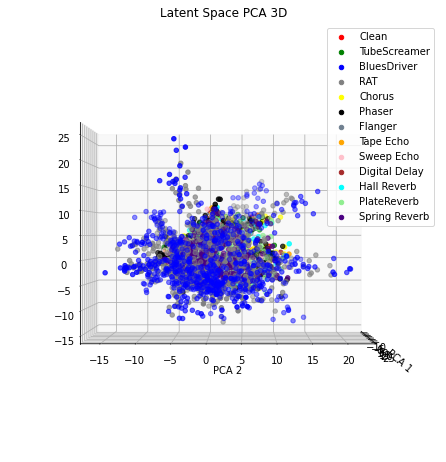

In [29]:
fig = plt.figure(1, figsize=(12, 6))
ax = Axes3D(fig,elev=-0, azim=0.4,auto_add_to_figure=False)

# create the PCA instance with the number of components to be computed 
pca = PCA(n_components= 3)

X_PCA = pca.fit_transform(latent[0])
print('variance: ')
print(pca.explained_variance_ratio_)

ax.scatter3D(X_PCA[:689, 0], X_PCA[:689, 1],X_PCA[:689, 2], c='red', label= fx[0])
ax.scatter3D(X_PCA[690:1379, 0], X_PCA[690:1379, 1],X_PCA[690:1379, 2], c='green', label= fx[1])
ax.scatter3D(X_PCA[1380:2069, 0], X_PCA[1380:2069, 1],X_PCA[1380:2069, 2], c='blue', label= fx[2])
ax.scatter3D(X_PCA[2070:2759, 0], X_PCA[2070:2759, 1],X_PCA[2070:2759, 2], c='gray', label= fx[3])
ax.scatter3D(X_PCA[2760:3449, 0], X_PCA[2760:3449, 1],X_PCA[2760:3449, 2], c='yellow', label= fx[4])
ax.scatter3D(X_PCA[3450:4139, 0], X_PCA[3450:4139, 1],X_PCA[3450:4139, 2], c='black', label= fx[5])
ax.scatter3D(X_PCA[4140:4829, 0], X_PCA[4140:4829, 1],X_PCA[4140:4829, 2], c='slategrey', label= fx[6])
ax.scatter3D(X_PCA[4830:5519, 0], X_PCA[4830:5519, 1],X_PCA[4830:5519, 2], c='orange', label= fx[7])
ax.scatter3D(X_PCA[5520:6209, 0], X_PCA[5520:6209, 1],X_PCA[5520:6209, 2], c='pink', label= fx[8])
ax.scatter3D(X_PCA[6210:6899, 0], X_PCA[6210:6899, 1],X_PCA[6210:6899, 2], c='brown', label= fx[9])
ax.scatter3D(X_PCA[6900:7589, 0], X_PCA[6900:7589, 1],X_PCA[6900:7589, 2], c='cyan', label= fx[10])
ax.scatter3D(X_PCA[7590:8279, 0], X_PCA[7590:8279, 1],X_PCA[7590:8279, 2], c='lightgreen', label= fx[11])
ax.scatter3D(X_PCA[8280:, 0], X_PCA[8280:, 1],X_PCA[8280:, 2], c='indigo', label= fx[12])

fig.add_axes(ax)
plt.legend()
plt.title('Latent Space PCA 3D')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
#plt.zlabel('PCA 3')

plt.show()

variance: 
[0.03250064 0.03029679]


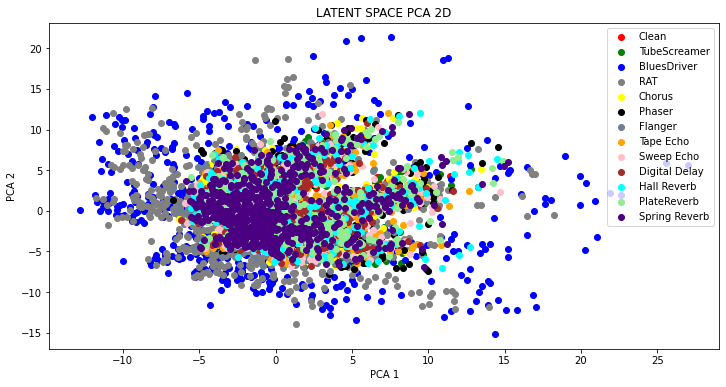

In [33]:
fig = plt.figure(1, figsize=(12, 6))
# create the PCA instance with the number of components to be computed 
pca = PCA(n_components= 2)

X_PCA = pca.fit_transform(latent[0])
print('variance: ')
print(pca.explained_variance_ratio_)

# "transform" the data that you want to reduce to "two components"
plt.scatter(X_PCA[:689, 0], X_PCA[:689, 1], c='red', label= fx[0])
plt.scatter(X_PCA[690:1379, 0], X_PCA[690:1379, 1], c='green', label= fx[1])
plt.scatter(X_PCA[1380:2069, 0], X_PCA[1380:2069, 1], c='blue', label= fx[2])
plt.scatter(X_PCA[2070:2759, 0], X_PCA[2070:2759, 1], c='gray', label= fx[3])
plt.scatter(X_PCA[2760:3449, 0], X_PCA[2760:3449, 1], c='yellow', label= fx[4])
plt.scatter(X_PCA[3450:4139, 0], X_PCA[3450:4139, 1], c='black', label= fx[5])
plt.scatter(X_PCA[4140:4829, 0], X_PCA[4140:4829, 1], c='slategrey', label= fx[6])
plt.scatter(X_PCA[4830:5519, 0], X_PCA[4830:5519, 1], c='orange', label= fx[7])
plt.scatter(X_PCA[5520:6209, 0], X_PCA[5520:6209, 1], c='pink', label= fx[8])
plt.scatter(X_PCA[6210:6899, 0], X_PCA[6210:6899, 1], c='brown', label= fx[9])
plt.scatter(X_PCA[6900:7589, 0], X_PCA[6900:7589, 1], c='cyan', label= fx[10])
plt.scatter(X_PCA[7590:8279, 0], X_PCA[7590:8279, 1], c='lightgreen', label= fx[11])
plt.scatter(X_PCA[8280:, 0], X_PCA[8280:, 1], c='indigo', label= fx[12])

plt.legend()
plt.title('LATENT SPACE PCA 2D')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

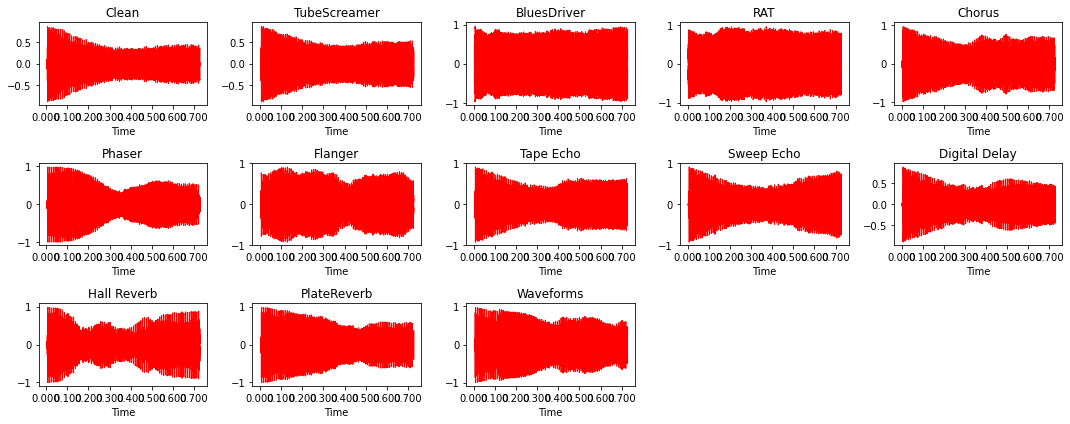

In [34]:
####visualización de los audios antes de normalizar
plt.figure(figsize=(15, 6))
sonidos = [i for i in range(115,len(Xw),690)]
for i, x in enumerate(sonidos):
    plt.subplot(3, 5, i+ 1).set_title(fx[i])
    librosa.display.waveshow(y_hat[x].flatten(),color='r')
plt.tight_layout()
plt.title("Waveforms")
plt.show()

In [36]:
import IPython.display
import numpy as np
import json

def Audio(audio: np.ndarray, sr: int):
    """
    Use instead of IPython.display.Audio as a workaround for VS Code.
    `audio` is an array with shape (channels, samples) or just (samples,) for mono.
    """

    if np.ndim(audio) == 1:
        channels = [audio.tolist()]
    else:
        channels = audio.tolist()

    return IPython.display.HTML("""
        <script>
            if (!window.audioContext) {
                window.audioContext = new AudioContext();
                window.playAudio = function(audioChannels, sr) {
                    const buffer = audioContext.createBuffer(audioChannels.length, audioChannels[0].length, sr);
                    for (let [channel, data] of audioChannels.entries()) {
                        buffer.copyToChannel(Float24Array.from(data), channel);
                    }
            
                    const source = audioContext.createBufferSource();
                    source.buffer = buffer;
                    source.connect(audioContext.destination);
                    source.start();
                }
            }
        </script>
        <button onclick="playAudio(%s, %s)">Play</button>
    """ % (json.dumps(channels), sr))

In [37]:
def latent_inter(audio_a, audio_b, step = 1):
  'step hace referencia al numero de audios entre las referencias'
  if step == 1:
    listas = np.linspace(audio_a, audio_b, step + 2).flatten()
  else:
    listas = np.linspace(audio_a, audio_b, step + 2)
  return listas

In [204]:
#print(latent_inter([0.1,0,0,0],[1,1,1,1],10))
#print()

In [95]:
num = 8
num2 =  10
primero = sonidos[num]
print(primero)
segundo = sonidos[num2]
gen_audio = 10
gen_latent = latent_inter(latent[0][primero],latent[0][segundo],gen_audio)
print(gen_latent.shape)

5635
(12, 128)


1/1 [==============================] - 0s 9ms/step


/var/folders/qs/3zzqvkk15cx77yqry0yt8x8h0000gn/T/ipykernel_13082/1985009147.py:8: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.display.waveshow(v[i],sr16k, color='green')


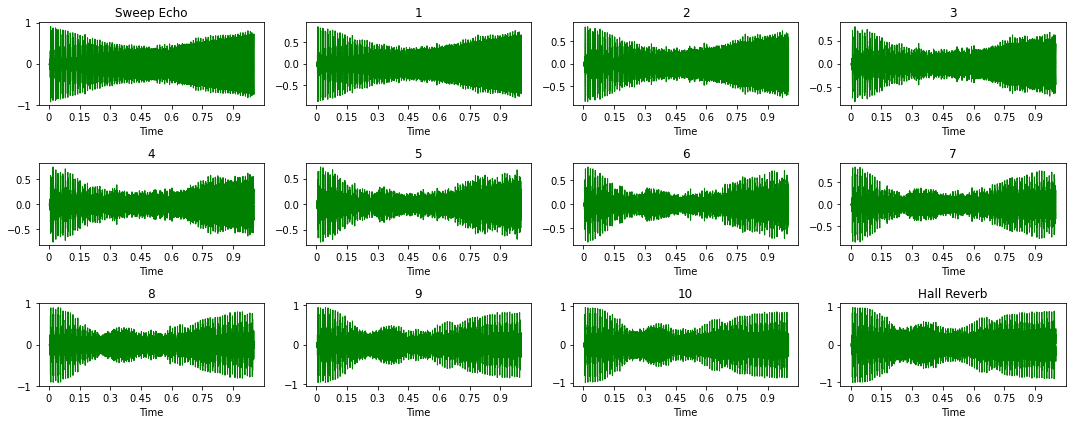

In [96]:
labels =[]
gen_latent = vae_decoder.predict(latent_inter(latent[0][primero],latent[0][segundo],gen_audio))
labels.extend([fx[num],1,2,3,4,5,6,7,8,9,10,fx[num2]])
v = [gen_latent[i].flatten() for i in range(gen_audio+2)]
plt.figure(figsize=(15, 6))#.suptitle("Gen waveform")
for i in range(gen_audio+2):
    plt.subplot(3,4, i+ 1).set_title(labels[i])
    librosa.display.waveshow(v[i],sr16k, color='green')
plt.tight_layout()
#plt.title()
plt.show()

In [100]:
Audio(v[11],sr16k)

In [101]:
from scipy.io.wavfile import write
for i in range(12):
    write("interpolation_"+fx[num]+fx[num2]+str(i)+".wav", sr16k, v[i])

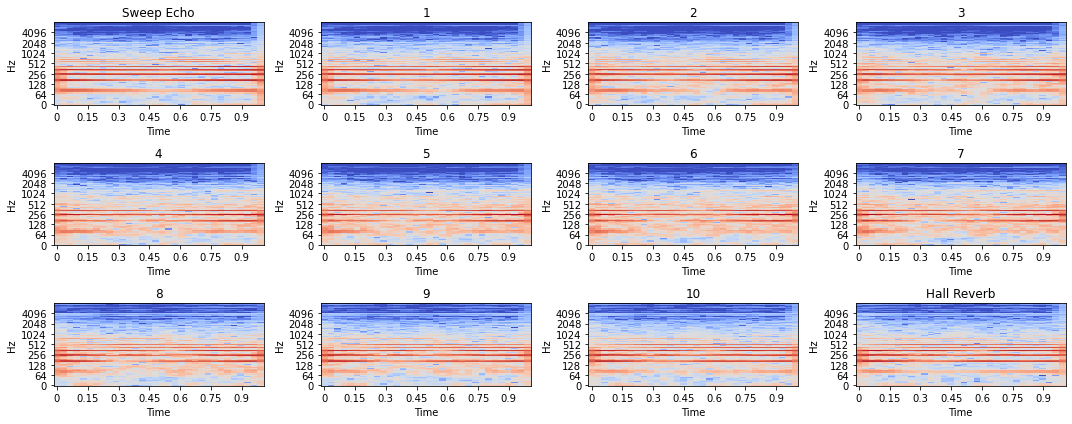

In [102]:
plt.figure(figsize=(15, 6))#.suptitle("STFT Data")
plt.title('stft')
for i in range(gen_audio+ 2):
    plt.subplot(3, 4, i + 1).set_title(labels[i])
    stft = librosa.stft(v[i])#, n_fft=512, hop_length= (512-1)//2)
    stft = librosa.amplitude_to_db(np.abs(stft))
    librosa.display.specshow(stft,sr = 16000, y_axis='log', x_axis='time')
plt.tight_layout()

plt.show()

In [336]:
######## octave interpolation
######## octave interpolation
######## octave interpolation
######## octave interpolation
######## octave interpolation
######## octave interpolation

paths = [
    '/Users/mezaga93/tensorflow-test/env/guitar_VAE/SampledGuitar/Stratocaster/1_Clean/Bridge-Middle/6-0.wav',
'/Users/mezaga93/tensorflow-test/env/guitar_VAE/SampledGuitar/Stratocaster/1_Clean/Bridge-Middle/6-12.wav'
]

y,fs = librosa.load(paths[1],48000)

y2 = librosa.resample(y[:48000],48000, 16000)

Audio(y2,sr16k)
#Audio(y,48000)




/var/folders/qs/3zzqvkk15cx77yqry0yt8x8h0000gn/T/ipykernel_12935/1969997483.py:5: FutureWarning: Pass sr=48000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y,fs = librosa.load(paths[1],48000)
/var/folders/qs/3zzqvkk15cx77yqry0yt8x8h0000gn/T/ipykernel_12935/1969997483.py:7: FutureWarning: Pass orig_sr=48000, target_sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y2 = librosa.resample(y[:48000],48000, 16000)


In [355]:
test_latent = []
sr = 48000
sr16k = 16000

for track in paths:
    y,fs = librosa.load(track,sr)
    test_latent.append(librosa.resample(y[:sr], sr, sr16k))
test_latent = np.array(test_latent)
print(test_latent.shape)

mu_latent = np.mean(test_latent, axis= 1)[...,np.newaxis]
max_latent = np.max(test_latent, axis=1)[...,np.newaxis]
Xw_latent = (test_latent- mu_latent)/max_latent

Xw_latent = Xw_latent[...,np.newaxis][...,np.newaxis]
print(Xw_latent.shape)



(2, 16000)
(2, 16000, 1, 1)


/var/folders/qs/3zzqvkk15cx77yqry0yt8x8h0000gn/T/ipykernel_12935/2470892463.py:6: FutureWarning: Pass sr=48000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y,fs = librosa.load(track,sr)
/var/folders/qs/3zzqvkk15cx77yqry0yt8x8h0000gn/T/ipykernel_12935/2470892463.py:7: FutureWarning: Pass orig_sr=48000, target_sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  test_latent.append(librosa.resample(y[:sr], sr, sr16k))


In [354]:
#Audio(Xw_latent[0],sr16k)


In [356]:
latent = vae_encoder.predict(Xw_latent)

1/1 [==============================] - 0s 58ms/step


In [ ]:
gen_latent = latent_inter(latent[0][0],latent[0][1],11)
print(gen_latent[0])
print(latent[0][0])

1/1 [==============================] - 0s 9ms/step
12


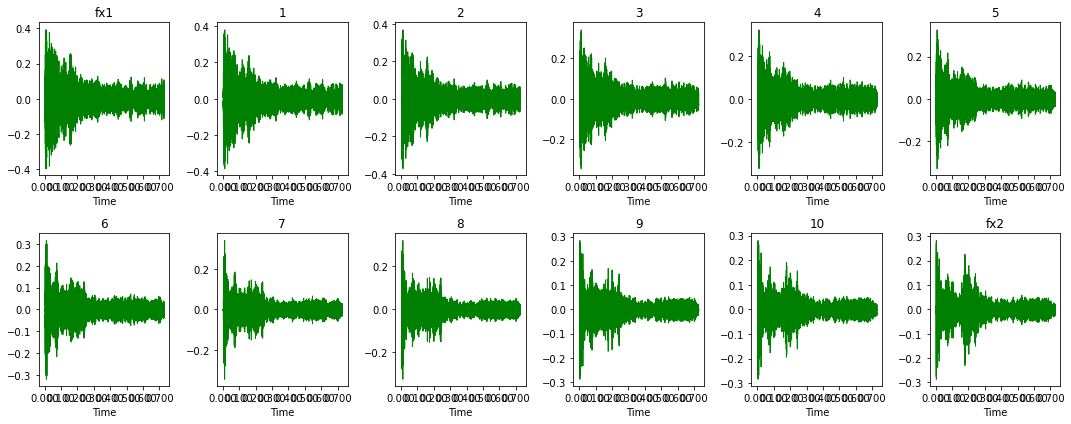

In [357]:
labels = []
labels.extend(['fx1',1,2,3,4,5,6,7,8,9,10,'fx2'])
gen_latent = vae_decoder.predict(latent_inter(latent[0][0],latent[0][1],11))
v = [gen_latent[i].flatten() for i in range(12)]
print(len(v))
plt.figure(figsize=(15, 6))#.suptitle("Gen waveform")
for i in range(gen_audio+2):
    plt.subplot(2, 6, i+ 1).set_title(labels[i])
    librosa.display.waveshow(v[i], color='green')
plt.tight_layout()
#plt.title()
plt.show()

In [359]:
Audio(v[11],sr16k)

1/1 [==============================] - 0s 64ms/step


2022-05-29 14:47:47.161909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12


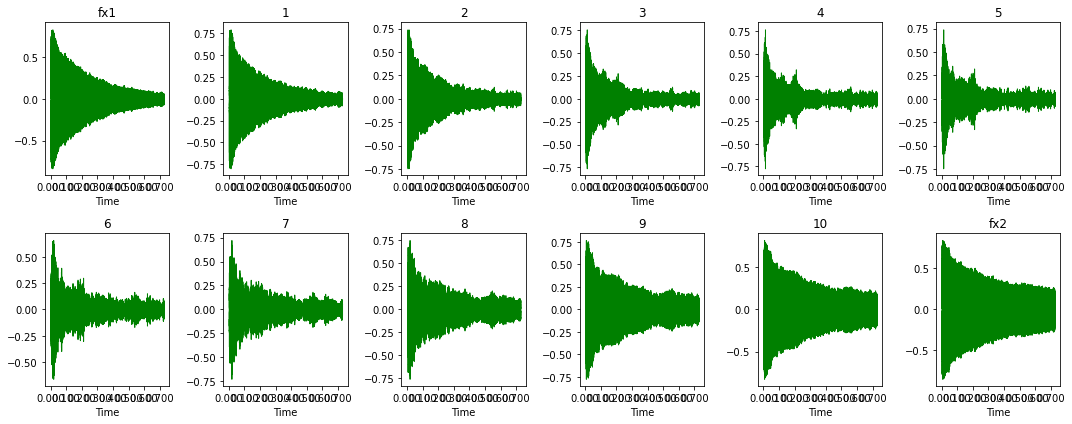

In [288]:
labels = []
labels.extend(['fx1',1,2,3,4,5,6,7,8,9,10,'fx2'])
gen_latent = vae_decoder.predict(latent_inter(latent[0][primero],latent[0][segundo],gen_audio))
v = [gen_latent[i].flatten() for i in range(12)]
print(len(v))
plt.figure(figsize=(15, 6))#.suptitle("Gen waveform")
for i in range(gen_audio+2):
    plt.subplot(2, 6, i+ 1).set_title(labels[i])
    librosa.display.waveshow(v[i], color='green')
plt.tight_layout()
#plt.title()
plt.show()


In [315]:
Audio(v[0],sr16k)

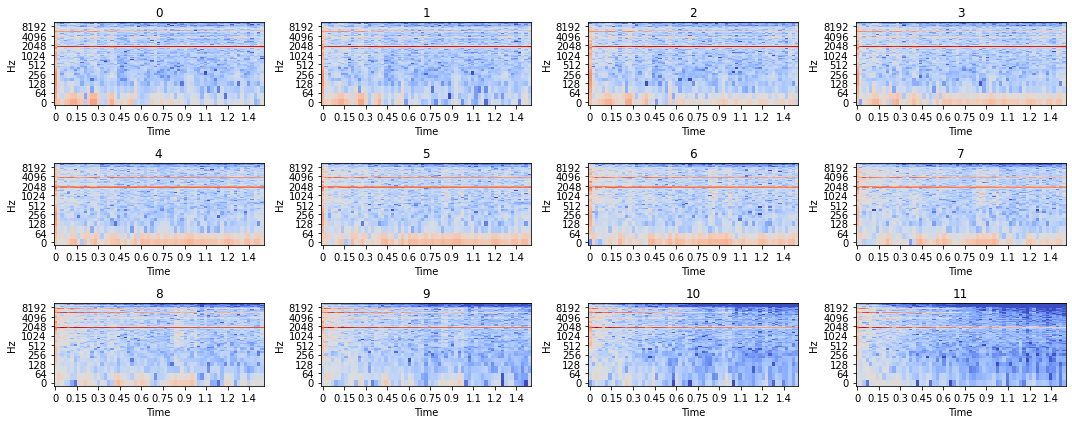

In [134]:
plt.figure(figsize=(15, 6))#.suptitle("STFT Data")
plt.title('stft')

for i in range(gen_audio+ 2):
    plt.subplot(3, 4, i + 1).set_title(i)
    stft = librosa.stft(v[i], n_fft=512, hop_length= (512-1)//2)
    stft = librosa.amplitude_to_db(np.abs(stft))
    librosa.display.specshow(stft, y_axis='log', x_axis='time')
plt.tight_layout()

plt.show()

In [ ]:
##########
def euclidean_distance(array1,array2):
    dist = np.linalg.norm(array1 - array2)
    return dist

In [ ]:
def latent_sonidos_near(k, matriz, n):
    lista = []
    for j,array in enumerate(matriz):
        a = euclidean_distance(k, array)
        lista.append(a)
    idx = np.argpartition(lista, n)
    result = [matriz[i] for i in idx[:n]]
    result = np.array(result)
    return result

In [ ]:
eucledean_near = latent_sonidos_near(latent[0][0], latent[0], 5)
#print(latent[0][0][:10])
#print(a[0][:10])
#print(euclidean_distance(latent[0][0], a[0]))
#print(a[1][:10])
#print(euclidean_distance(latent[0][0], a[1]))
#print(euclidean_distance(latent[0][0], a[2]))
#eucledean_near = np.array(eucledean_near)
print(eucledean_near.shape)

In [ ]:
gen_latent = vae_decoder.predict(eucledean_near)
v = [gen_latent[i].flatten() for i in range(5)]
plt.figure(figsize=(15, 6))#.suptitle("Gen waveform")
for i in range(5):
    plt.subplot(1, 5, i+ 1)#.set_title(i)
    librosa.display.waveshow(v[i], color='rebeccapurple')
plt.tight_layout()
#plt.title()
plt.show()

In [ ]:
Audio(v[0],sr16k)